# Bottleneck Attention Module
* Refference: [Bottleneck Attention Module](https://arxiv.org/abs/1807.06514)

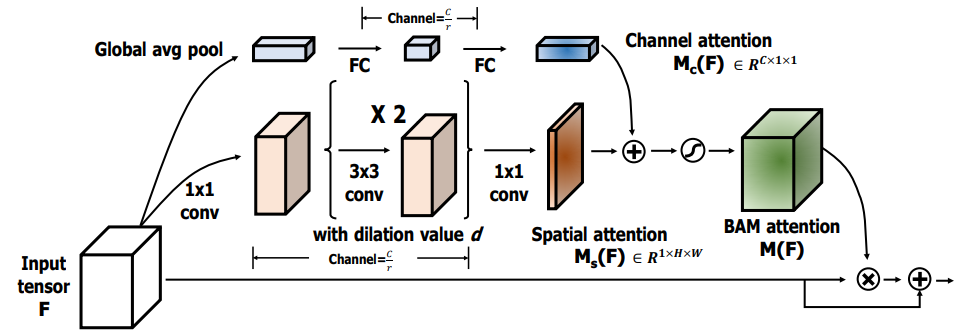

## Bottleneck Attention Module
When $M(F)$ is defined bottleneck attention module,
$
M(F)=\sigma(M_c(F)+M_s(F))\qquad \text{where }\sigma\text{ denots sigmoid activation function} 
$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Channel Attention Branch
$
M_c(F)=BN(MLP(AvgPool(F)))\\
\qquad\quad= BN(W_1(W_0AvgPool(F)+b_0)+b_1)
$

In [ ]:
def avg_pool(x, kernel_size, stride):
    x = F.avg_pool2d(x, kernel_size=kernel_size, stride=stride)
    return x.view(x.size(0), -1)

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, cin, r=16):
        super().__init__()
        cinter = cin // r
        self.fc1 = nn.Linear(
            in_features=cin, out_features=cinter)
        self.fc2 = nn.Linear(
            in_features=cinter, out_features=cin)
        self.bn = nn.BatchNorm1d(num_features=cinter)

    def forward(self, x):
        x = avg_pool(x, kernel_size=x.size(2), stride=x.size(2))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn(x)
        x = self.fc2(x)
        return x.unsqueeze(2).unsqueeze(3)

In [ ]:
mc = ChannelAttention(256)
x = torch.randn((5, 256, 10, 10))

In [ ]:
mc(x).size()

torch.Size([5, 256, 1, 1])

### Spatial Attention Branch
$
M_s(F)=BN(f_3^{1\times1}(f_2^{3\times3}(f_1^{3\times3}(f_0^{1\times1}(F)))))\qquad
$

$f$ denotes convolution and its superscripts denote kernel size. Two 1$\times$1 convolutions reduce output feature map channel and 3$\times$3 convolutions in the middle is dilated convolutions.

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self, cin, d=4, r=16):
        super().__init__()
        cinter = cin // r
        self.conv1 = nn.Conv2d(
            in_channels=cin, out_channels=cinter, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(num_features=cinter)
        self.conv2 = nn.Conv2d(
            in_channels=cinter, out_channels=cinter, kernel_size=3, padding=d, dilation=d)
        self.bn2 = nn.BatchNorm2d(num_features=cinter)
        self.conv3 = nn.Conv2d(
            in_channels=cinter, out_channels=cinter, kernel_size=3, padding=d, dilation=d)
        self.bn3 = nn.BatchNorm2d(num_features=cinter)
        self.conv4 = nn.Conv2d(
            in_channels=cinter, out_channels=1, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        return self.conv4(x)

In [ ]:
ms = SpatialAttention(256)
x = torch.randn((5, 256, 16, 16))
ms(x).size()

torch.Size([5, 1, 16, 16])

### Combining attention branches
There are 3 choices to combine different sized tensor.

1. element-wise addition
2. element-wise multiplication
3. max operation

Among 3 mothds element-wise addition results in the best preformece

$
F'=F+F\otimes M(F)\\
\quad  = F\cdot(1+M(F))
$

In [ ]:
class BottleneckAttention(nn.Module):
    def __init__(self, cin, d=4, r=16):
        super().__init__()
        self.Mc = ChannelAttention(cin=cin, r=r)
        self.Ms = SpatialAttention(cin=cin, d=d, r=r)

    def forward(self, x):
        c = self.Mc(x)    # [N, C, 1, 1]
        s = self.Ms(x)    # [N, 1, H, W]
        s = s.expand_as(x)
        att = torch.sigmoid(c + s)
        return x * (1 + att)

In [ ]:
x = torch.randn((5, 256, 16, 16))
ba = BottleneckAttention(256)
ba(x).size()

torch.Size([5, 256, 16, 16])

### Ablation study on dilation value, reduction ratio and combining methods

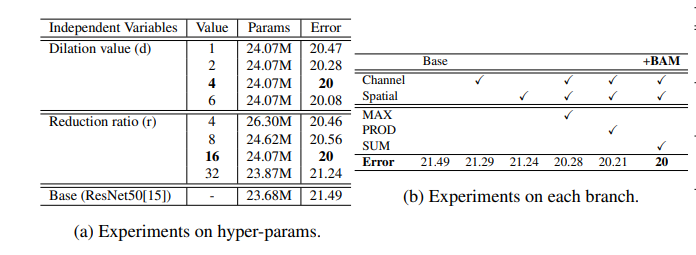